In [1]:
import torch
import torchvision

from model import ViT, RegressionHead, ClassificationHead
from rotationPrediction import RotationPredictionDataset

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10
img_size = 56

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(device)
pretext_dataset = RotationPredictionDataset(root='./images/train', train=True, download=True,
                                           transform=torchvision.transforms.Compose([
                                               torchvision.transforms.Resize((img_size, img_size)),
                                               torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                           ]))
pretext_dataset_test = RotationPredictionDataset(root='./images/test', train=False, download=True,
                                             transform=torchvision.transforms.Compose([
                                                  torchvision.transforms.Resize((img_size, img_size)),
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                             ]))

pretext_dataset_test_loader = torch.utils.data.DataLoader(pretext_dataset_test, batch_size=batch_size_test, shuffle=True)


train_loader = torch.utils.data.DataLoader(pretext_dataset, batch_size=batch_size_train, shuffle=True)

classification_train_loader = torch.utils.data.DataLoader(torchvision.datasets.FashionMNIST('./images/train', train=True, download=True,
                                            transform=torchvision.transforms.Compose([
                                                torchvision.transforms.Resize((img_size, img_size)),
                                                torchvision.transforms.ToTensor(),
                                                torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                            ])), batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(torchvision.datasets.FashionMNIST('./images/test', train=False, download=True,
                                           transform=torchvision.transforms.Compose([
                                               torchvision.transforms.Resize((img_size, img_size)),
                                               torchvision.transforms.ToTensor(),
                                               torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                           ])), batch_size=batch_size_test, shuffle=True)


'''

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.FashionMNIST('./images/train', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                                torchvision.transforms.Resize((img_size, img_size)),
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.FashionMNIST('./images/test', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                                 torchvision.transforms.Resize((img_size, img_size)),
                                 torchvision.transforms.ToTensor(),
                                 torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

'''


mps


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26421880/26421880 [00:03<00:00, 8403865.56it/s]


Extracting ./images/test/RotationPredictionDataset/raw/train-images-idx3-ubyte.gz to ./images/test/RotationPredictionDataset/raw



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 899515.22it/s]

Extracting ./images/test/RotationPredictionDataset/raw/train-labels-idx1-ubyte.gz to ./images/test/RotationPredictionDataset/raw



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4422102/4422102 [00:00<00:00, 7941549.65it/s]


Extracting ./images/test/RotationPredictionDataset/raw/t10k-images-idx3-ubyte.gz to ./images/test/RotationPredictionDataset/raw



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<00:00, 5529392.32it/s]

Extracting ./images/test/RotationPredictionDataset/raw/t10k-labels-idx1-ubyte.gz to ./images/test/RotationPredictionDataset/raw


"\n\ntrain_loader = torch.utils.data.DataLoader(\n  torchvision.datasets.FashionMNIST('./images/train', train=True, download=True,\n                             transform=torchvision.transforms.Compose([\n                                torchvision.transforms.Resize((img_size, img_size)),\n                                torchvision.transforms.ToTensor(),\n                                torchvision.transforms.Normalize(\n                                 (0.1307,), (0.3081,))\n                             ])),\n  batch_size=batch_size_train, shuffle=True)\n\ntest_loader = torch.utils.data.DataLoader(\n  torchvision.datasets.FashionMNIST('./images/test', train=False, download=True,\n                             transform=torchvision.transforms.Compose([\n                                 torchvision.transforms.Resize((img_size, img_size)),\n                                 torchvision.transforms.ToTensor(),\n                                 torchvision.transforms.Normalize(\n            

In [4]:
encoder = ViT(in_channels=1, n_classes=10, img_size=img_size,
            depth=3, emb_size=192)

decoder = ClassificationHead(emb_size=192, n_classes=10)

regressionModel = torch.nn.Sequential(
    encoder, RegressionHead(emb_size=192)
)
classificationModel = torch.nn.Sequential(
    encoder, decoder
)

rotation_loss = torch.nn.CrossEntropyLoss()
rotation_optimizer = torch.optim.SGD(regressionModel.parameters(), lr=learning_rate, momentum=momentum)

classification_loss = torch.nn.CrossEntropyLoss()
classification_optimizer = torch.optim.SGD(classificationModel.parameters(), lr=learning_rate,
                            momentum=momentum)

In [5]:
# training loop
'''
losses = []
accuracies = []

for epoch in range(n_epochs):
    # train
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()
        output = model(data)
        
        loss_val = loss(output, target)
        loss_val.backward()
        optimizer.step()
        
        losses.append(loss_val.item())
        accuracies.append((output.argmax(dim=1) == target).float().mean().item())
            
    # test
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += loss(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
          .format(test_loss, correct, len(test_loader.dataset),
                  100. * correct / len(test_loader.dataset)))
'''

regression_losses = []
regression_accuracies = []

for epoch in range(n_epochs):
    regressionModel.train()
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        rotation_optimizer.zero_grad()
        output = regressionModel(data)
        #print(output.shape, target.shape)
        #print(output, target)
        loss_val = rotation_loss(output, target)
        #print(loss_val)
        
        loss_val.backward()
        rotation_optimizer.step()

        regression_losses.append(loss_val.item())
        regression_accuracies.append((output.argmax(dim=1) == target).float().mean().item())

    
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in pretext_dataset_test_loader:
            output = regressionModel(data)
            test_loss += rotation_loss(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(pretext_dataset_test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
        .format(test_loss, correct, len(pretext_dataset_test_loader.dataset), 100. * correct / len(pretext_dataset_test_loader.dataset)))




  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0011, Accuracy: 7063/10000 (71%)


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8056/10000 (81%)


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0009, Accuracy: 8659/10000 (87%)


In [6]:
classification_losses = []
classification_accuracies = []

for epoch in range(n_epochs):
    for batch_idx, (data, target) in enumerate(tqdm(classification_train_loader)):
        classification_optimizer.zero_grad()
        output = classificationModel(data)
        #print(output.shape, target.shape)
        #print(output)
        loss_val = classification_loss(output, target)
        #print(loss_val)
        
        loss_val.backward()
        classification_optimizer.step()

        classification_losses.append(loss_val.item())
        classification_accuracies.append((output.argmax(dim=1) == target).float().mean().item())
    
    test_loss = 0
    correct = 0
    classificationModel.eval()
    with torch.no_grad():
        for data, target in test_loader:
            output = classificationModel(data)
            test_loss += classification_loss(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
        .format(test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))

  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 7506/10000 (75%)


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 7832/10000 (78%)


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 8117/10000 (81%)


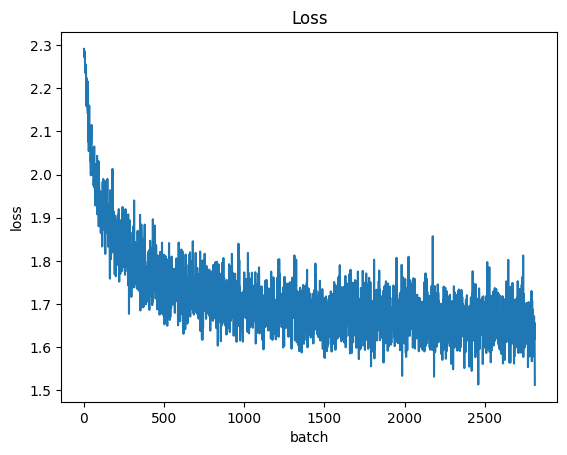

ValueError: buffer is not large enough

In [10]:
 #plot losses

plt.plot(classification_losses)
plt.title('Loss')
plt.xlabel('batch')
plt.ylabel('loss')
plt.show()

plt.imsave('classification_losses.png', classification_losses)




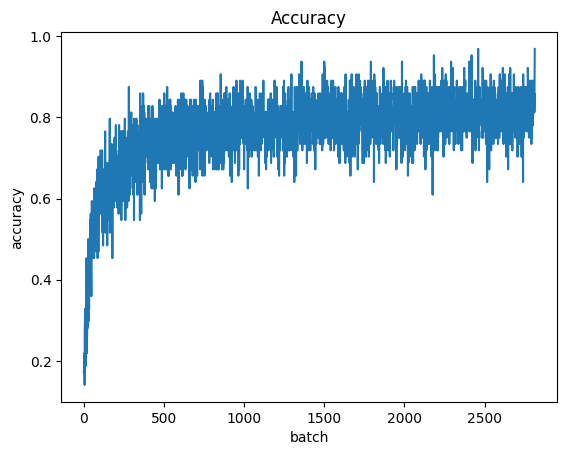

In [8]:
# plot accuracies

plt.plot(classification_accuracies)
plt.title('Accuracy')
plt.xlabel('batch')
plt.ylabel('accuracy')
plt.show()

plt.imsave('classification_accuracies.png', classification_accuracies)


In [9]:
encoder_test = ViT(in_channels=1, n_classes=10, img_size=img_size,
            depth=3, emb_size=192)

decoder_test = ClassificationHead(emb_size=192, n_classes=10)


classificationModel_test = torch.nn.Sequential(
    encoder_test, decoder_test
)


classification_loss_test = torch.nn.CrossEntropyLoss()
classification_optimizer_test = torch.optim.SGD(classificationModel_test.parameters(), lr=learning_rate,
                            momentum=momentum)


classification_losses_test = []
classification_accuracies_test = []

for epoch in range(n_epochs):
    for batch_idx, (data, target) in enumerate(tqdm(classification_train_loader)):
        classification_optimizer_test.zero_grad()
        output = classificationModel_test(data)
        #print(output.shape, target.shape)
        #print(output)
        loss_val_test = classification_loss_test(output, target)
        #print(loss_val)
        
        loss_val_test.backward()
        classification_optimizer_test.step()

        classification_losses_test.append(loss_val.item())
        classification_accuracies_test.append((output.argmax(dim=1) == target).float().mean().item())
    
    test_loss_test = 0
    correct_test = 0
    classificationModel.eval()
    with torch.no_grad():
        for data, target in test_loader:
            output = classificationModel_test(data)
            test_loss_test += classification_loss_test(output, target).item()
            pred_test = output.argmax(dim=1, keepdim=True)
            correct_test += pred_test.eq(target.view_as(pred_test)).sum().item()

    test_loss_test /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
        .format(test_loss_test, correct_test, len(test_loader.dataset), 100. * correct_test / len(test_loader.dataset)))

  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0018, Accuracy: 7091/10000 (71%)


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 7587/10000 (76%)


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0017, Accuracy: 7961/10000 (80%)
